In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

注意点：  

- b 零初始值
- w 初始化要用 tf，不要用 np

In [129]:
# 读取数据集MNIST，并放在当前目录data文件夹下MNIST文件夹中，如果该地址没有数据，则下载数据至该文件夹
# 一张图片有 28*28=784 个像素点，每个点用一个浮点数表示其亮度；
mnist = input_data.read_data_sets("./data/MNIST/", one_hot=True)

Extracting ./data/MNIST/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/t10k-labels-idx1-ubyte.gz


In [130]:
#该函数用于输出生成图片

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [131]:
batch_size = 128
z_dim = 200

In [132]:
def variable_init(size):
    # He initialization: sqrt(2./dim of the previous layer)
    # np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
    in_dim = size[0]
    return tf.random_normal(shape=size, stddev=np.sqrt(2./in_dim))

In [133]:
# 定义并初始化变量

X = tf.placeholder(tf.float32, shape=(None, 784))
Z = tf.placeholder(tf.float32, shape=(None, z_dim))

DW1 = tf.Variable(variable_init([784, 128]))
Db1 = tf.Variable(tf.zeros(shape=[128]))
DW2 = tf.Variable(variable_init([128, 1]))
Db2 = tf.Variable(tf.zeros(shape=[1]))
theta_D = [DW1, DW1, Db1, Db2]

GW1 = tf.Variable(variable_init([z_dim, 128]))
Gb1 = tf.Variable(tf.zeros(shape=[128]))
GW2 = tf.Variable(variable_init([128, 784]))
Gb2 = tf.Variable(tf.zeros(shape=[784]))
theta_G = [GW1, GW2, Gb1, Gb2]

In [134]:
# 定义随机噪声生成器
# 函数 Z，生成 z
def noise_maker(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n])

In [135]:
# 定义数据生成器，将 z 变成 概率分布
# 生成的结果为：是不是图片
# 生成 N * 784 的结果

def generator(z):
    
    # tanh, relu。。。都可以
    Gh1 = tf.nn.relu(tf.matmul(z, GW1) + Gb1)
    G_logit = tf.matmul(Gh1, GW2) + Gb2
    # 这里用 sigmoid 是因为不需要加起来概率等于 1
    G_prob = tf.nn.sigmoid(G_logit)
    return G_prob

In [136]:
# 定义判别器

def discriminator(x):
    
    # tanh relu。。。
    Dh1 = tf.nn.relu(tf.matmul(x, DW1) + Db1)
    D_logit = tf.matmul(Dh1, DW2) + Db2
#     D_prob = tf.nn.sigmoid(D_logit)
    return D_logit # , D_prob

In [137]:
# 定义损失函数

D_real_logit = discriminator(X) # D_real_prob, 
D_fake_logit = discriminator(generator(Z)) # D_fake_prob, 

D_X = tf.concat([D_real_logit, D_fake_logit], 1)
D_y = tf.concat([tf.ones_like(D_real_logit), tf.zeros_like(D_fake_logit)], 1)

D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_X, labels=D_y))
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logit, labels=tf.ones_like(D_fake_logit)))

D_opt = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_opt = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [139]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

if not os.path.exists('out_exercise/'):
    os.makedirs('out_exercise/')

i = 0
for it in range(20000):
    
    if it % 2000 == 0:
        # 16 幅图
        samples = sess.run(generator(Z), feed_dict={Z: noise_maker(16, z_dim)})
        fig = plot(samples)
        plt.savefig('out_exercise/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
    
    X_mb, _ = mnist.train.next_batch(batch_size)
    
    _, D_loss_curr = sess.run([D_opt, D_loss], feed_dict={X: X_mb, Z: noise_maker(batch_size, z_dim)})
    _, G_loss_curr = sess.run([G_opt, G_loss], feed_dict={Z: noise_maker(batch_size, z_dim)})

#     sam,fakeprob,fakelogit = sess.run([generator(Z), D_fake_prob, D_fake_logit], 
#                                       feed_dict={X: X_mb, Z: noise_maker(batch_size, z_dim)})

    
    if it % 2000 == 0:
        print('Iter: {}  D_loss: {:.4}, G_loss: {:.4}'.format(it, D_loss_curr, G_loss_curr))

Iter: 0  D_loss: 0.8844, G_loss: 6.359
Iter: 2000  D_loss: 0.005452, G_loss: 8.601
Iter: 4000  D_loss: 0.03211, G_loss: 5.053
Iter: 6000  D_loss: 0.05437, G_loss: 6.873
Iter: 8000  D_loss: 0.08955, G_loss: 4.662
Iter: 10000  D_loss: 0.1231, G_loss: 3.741
Iter: 12000  D_loss: 0.2174, G_loss: 2.919
Iter: 14000  D_loss: 0.2096, G_loss: 3.576
Iter: 16000  D_loss: 0.2404, G_loss: 2.987
Iter: 18000  D_loss: 0.3235, G_loss: 2.675


In [140]:
samples.shape

(16, 784)

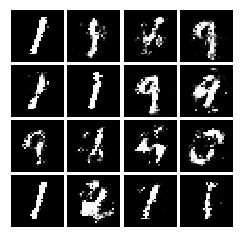

In [141]:
plot(samples)